## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from glob import glob
from sklearn import model_selection
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.models import model_from_json

%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
92978,00023211_007.png,No Finding,7,23211,30,F,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00023211_007.png
82795,00020340_001.png,Infiltration|Mass,1,20340,72,M,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00020340_001.png
55566,00013917_002.png,No Finding,2,13917,52,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00013917_002.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
# all_xray_df['labels'] = 1 if all_xray_df['Finding Labels'].str.contains('Pneumonia') else 0
all_xray_df.loc[all_xray_df['Finding Labels'].str.contains('Pneumonia'), 'labels'] = 1
all_xray_df['labels'] = all_xray_df['labels'].fillna(0)



In [4]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,labels
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png,0.0


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df.loc[all_xray_df['Finding Labels'].str.contains('Pneumonia'), 'pneumonia_class'] = "Y"
all_xray_df['pneumonia_class'] = all_xray_df['pneumonia_class'].fillna("N")

In [6]:
all_xray_df['pneumonia_class'].value_counts()

N    110689
Y      1431
Name: pneumonia_class, dtype: int64

## Create your training and testing data:

In [7]:
def create_splits(**vargs):
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    from random import sample

    df = vargs['df']
    train_df, valid_df = model_selection.train_test_split(df, test_size = 0.2, stratify = df['pneumonia_class'])
    
    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    
    print(f'Initial split. Train set pneumonia: {100.0*train_df_ratio :.2f}%. Valid set pneumonia: {100.0*valid_df_ratio :.2f}%')
    
    # make training set contain same number of positive and negative cases
    train_pos_inds = train_df[train_df['pneumonia_class'] == 'Y'].index.tolist()
    train_neg_inds = train_df[train_df['pneumonia_class'] == 'N'].index.tolist()

    train_neg_sample = sample(train_neg_inds, len(train_pos_inds))
    train_df = train_df.loc[train_pos_inds + train_neg_sample]

    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    print(f'Train set corrected (50/50), pneumonia: {100.0*train_df_ratio :.2f}%')
    
    # make validation set contain 80% positive and 20% negative cases
    valid_pos_inds = valid_df[valid_df['pneumonia_class'] == 'Y'].index.tolist()
    valid_neg_inds = valid_df[valid_df['pneumonia_class'] == 'N'].index.tolist()

    valid_neg_sample = sample(valid_neg_inds, 4*len(valid_pos_inds))
    valid_df = valid_df.loc[valid_pos_inds + valid_neg_sample]

    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Valid set corrected (20/80), pneumonia: {100.0*valid_df_ratio :.2f}%')

    return train_df, valid_df
    
    
    

In [8]:
df_train, df_valid = create_splits(df = all_xray_df)
print(f'Train set size: {len(df_train)}, valid set size: {len(df_valid)}')

Initial split. Train set pneumonia: 1.28%. Valid set pneumonia: 1.28%
Train set corrected (50/50), pneumonia: 50.00%
Valid set corrected (20/80), pneumonia: 20.00%
Train set size: 2290, valid set size: 1430


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [9]:
def my_image_augmentation(**vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    rotation = vargs['rotation'] if 'rotation' in vargs else 30
    shear = vargs['shear'] if 'shear' in vargs else 0.2
    zoom = vargs['zoom'] if 'rotation' in vargs else 0.2
    
    my_idg = ImageDataGenerator(
        rescale=1. / 255.0, 
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range = 0.1, 
        width_shift_range = 0.1, 
        rotation_range = rotation, 
        shear_range = shear,
        zoom_range = zoom)
    
    return my_idg


def make_train_gen(**vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    df_train = vargs['df']
    my_train_idg = my_image_augmentation(**vargs)
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=df_train, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (224, 224), 
                                         batch_size = 32
                                         )
    return train_gen


def make_val_gen(**vargs):
    df_val = vargs['df']
    ### Only rescaling validation set images
    my_val_idg = ImageDataGenerator(rescale=1.0/255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = df_val, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224, 224), 
                                             batch_size = 64) 
    
    return val_gen

In [10]:
train_gen = make_train_gen(df = df_train)
valid_gen = make_val_gen(df = df_valid)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [11]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = valid_gen.next()

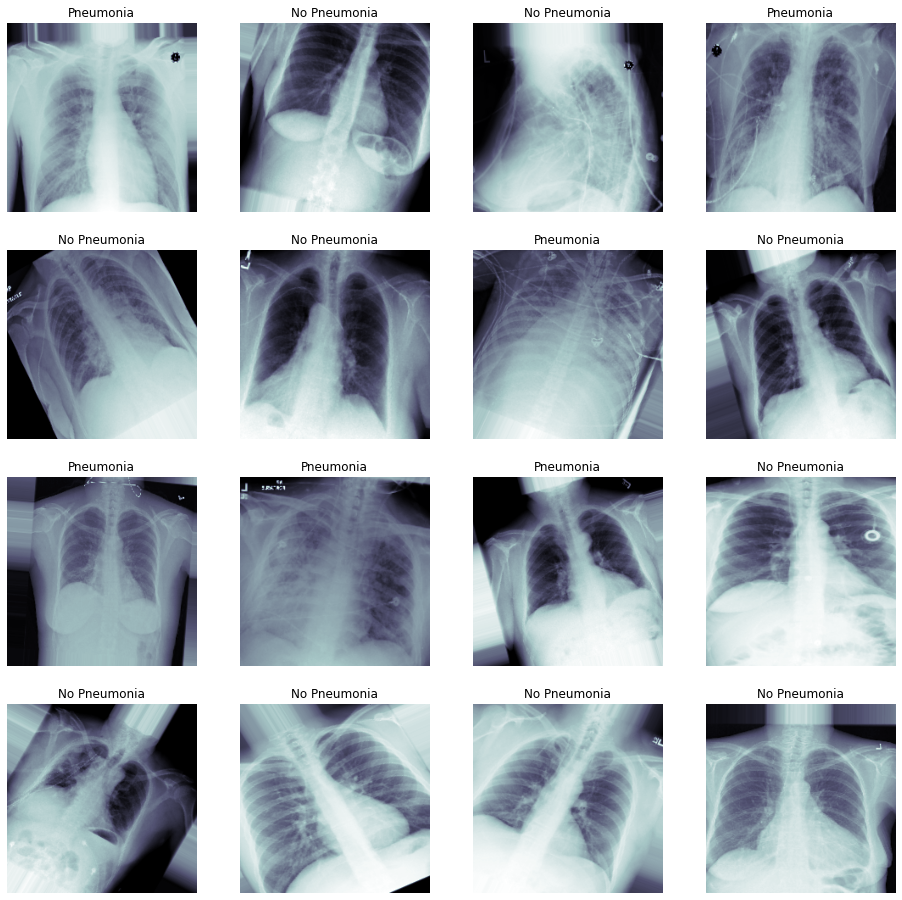

In [12]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
fig.savefig('train_images.png')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
def load_pretrained_model(**vargs):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    print('VGG16 layers:')
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
    return vgg_model


In [14]:
def build_my_model(**vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model = load_pretrained_model()
    my_model = Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    
    my_model.add(Dropout(0.2))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results


In [15]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)


callbacks_list = [checkpoint, early]

In [16]:
my_model = build_my_model()
my_model.summary()

553467904/553467096 [==============================] - 8s 0us/step
VGG16 layers:
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)     

### Start training! 

In [17]:
## train your model

# Todo
### compile model
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list)

Epoch 1/30
72/72 [==============================] - 68s 941ms/step - loss: 0.7055 - binary_accuracy: 0.5624 - val_loss: 0.5501 - val_binary_accuracy: 0.7656

Epoch 00001: val_loss improved from inf to 0.55009, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
72/72 [==============================] - 61s 848ms/step - loss: 0.6812 - binary_accuracy: 0.5873 - val_loss: 0.5705 - val_binary_accuracy: 0.6875

Epoch 00002: val_loss did not improve from 0.55009
Epoch 3/30
72/72 [==============================] - 61s 846ms/step - loss: 0.6470 - binary_accuracy: 0.6306 - val_loss: 0.6800 - val_binary_accuracy: 0.6250

Epoch 00003: val_loss did not improve from 0.55009
Epoch 4/30
72/72 [==============================] - 62s 860ms/step - loss: 0.6478 - binary_accuracy: 0.6384 - val_loss: 0.5137 - val_binary_accuracy: 0.7656

Epoch 00004: val_loss improved from 0.55009 to 0.51369, saving model to xray_class_my_model.best.hdf5
Epoch 5/30
72/72 [==============================] - 60s 836ms/step

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [18]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 1s 10ms/step


In [19]:
from sklearn.metrics import roc_curve
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')    
    plt.show()
    plt.savefig('auc.png')

## what other performance statistics do you want to include here besides AUC? 

def plot_val_loss(history):
    f = plt.figure()
    f.set_figwidth(10)
    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()

    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
    plt.plot(history.history['binary_accuracy'], label='train accuracy')
    plt.legend()
    plt.savefig('val_loss.png')



    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig('history.png')


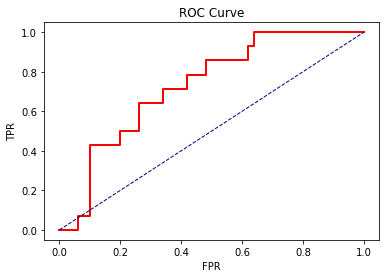

<Figure size 432x288 with 0 Axes>

In [20]:
## plot figures

# Todo
plot_auc(valY, pred_Y)


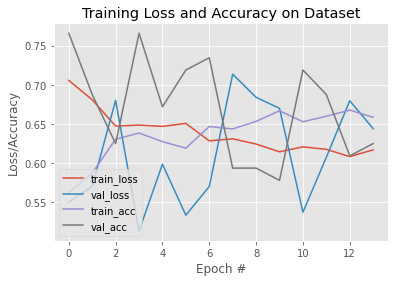

In [21]:
plot_history(history)

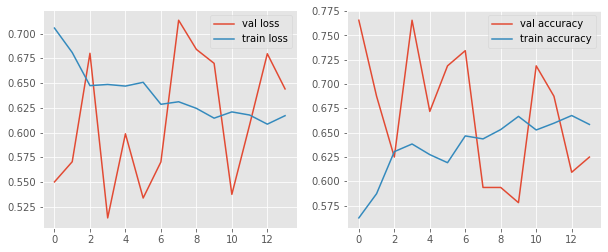

In [22]:
plot_val_loss(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [23]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
from sklearn.metrics import precision_recall_curve, average_precision_score
# Todo
def plot_pr_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    fig.savefig('pr_curve.png')

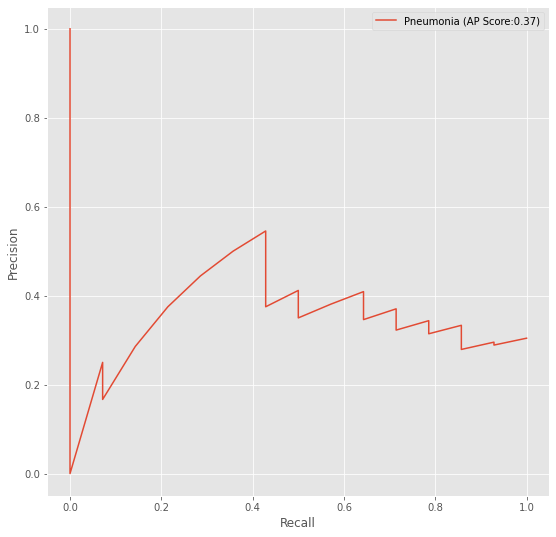

In [24]:
plot_pr_curve(valY, pred_Y)

In [25]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
F1 = 2 * (precision * recall) / (precision + recall)
np.mean(F1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


nan

In [26]:
print(f"Precision:{precision}\nRecall:{recall}")

Precision:[0.30434783 0.28888889 0.29545455 0.27906977 0.28571429 0.29268293
 0.3        0.30769231 0.31578947 0.32432432 0.33333333 0.31428571
 0.32352941 0.33333333 0.34375    0.32258065 0.33333333 0.34482759
 0.35714286 0.37037037 0.34615385 0.36       0.375      0.39130435
 0.40909091 0.38095238 0.35       0.36842105 0.38888889 0.41176471
 0.375      0.4        0.42857143 0.46153846 0.5        0.54545455
 0.5        0.44444444 0.375      0.28571429 0.16666667 0.2
 0.25       0.         0.         0.         1.        ]
Recall:[1.         0.92857143 0.92857143 0.85714286 0.85714286 0.85714286
 0.85714286 0.85714286 0.85714286 0.85714286 0.85714286 0.78571429
 0.78571429 0.78571429 0.78571429 0.71428571 0.71428571 0.71428571
 0.71428571 0.71428571 0.64285714 0.64285714 0.64285714 0.64285714
 0.64285714 0.57142857 0.5        0.5        0.5        0.5
 0.42857143 0.42857143 0.42857143 0.42857143 0.42857143 0.42857143
 0.35714286 0.28571429 0.21428571 0.14285714 0.07142857 0.07142857
 0

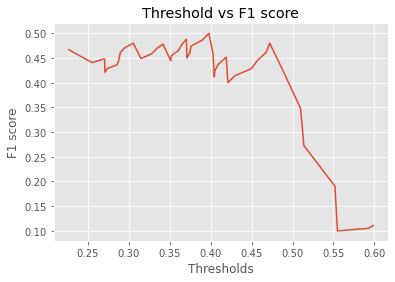

In [27]:
F1 = np.delete(F1, -1)
plt.plot(thresholds, F1)
plt.xlabel('Thresholds')
plt.ylabel('F1 score')
plt.title('Threshold vs F1 score')
plt.show()

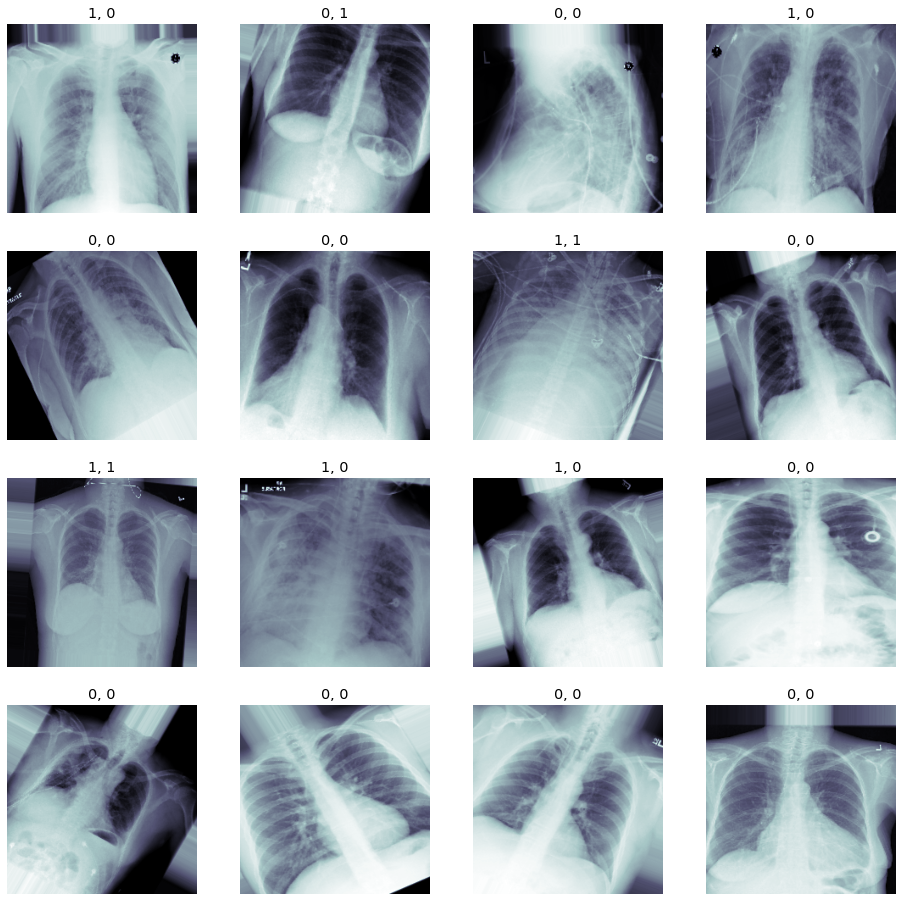

In [31]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

YOUR_THRESHOLD = 0.40

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(t_x[0:100], t_y[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

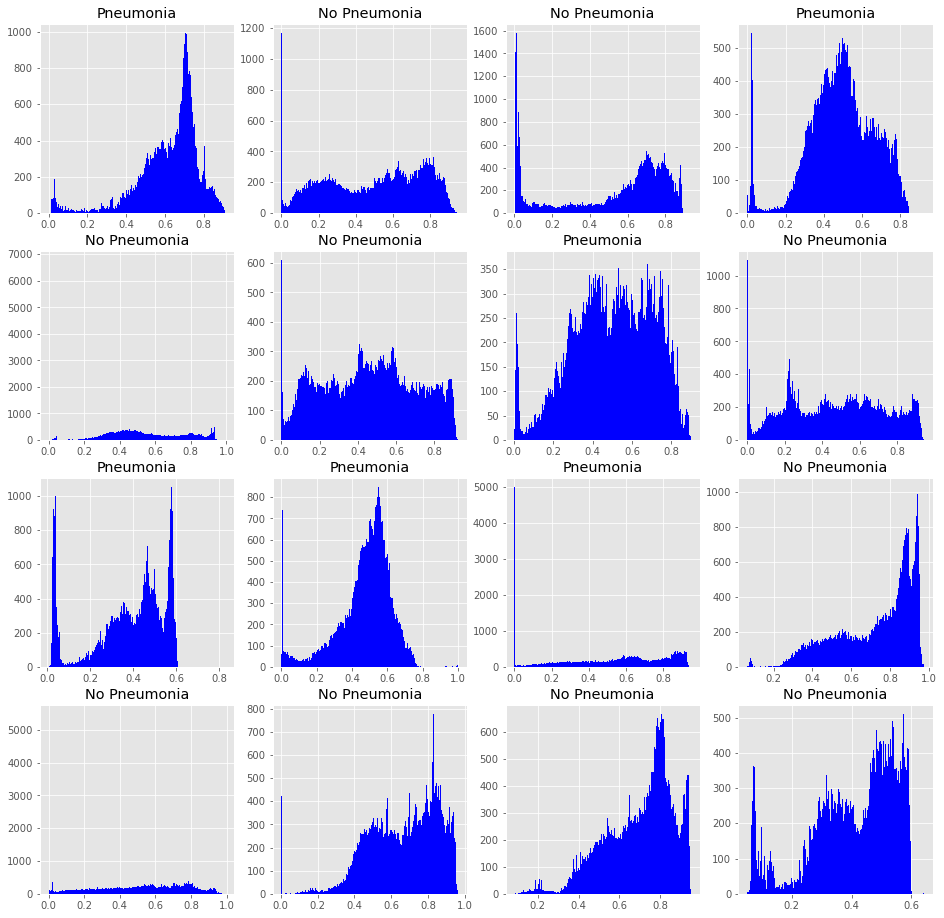

In [32]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):

    c_ax.hist(c_x[:,:,0].flatten(), bins = 256, color='blue')
    
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')

plt.show()

In [33]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)